# iWildCam Classification Notebook

## Problem:
Given sufficient data, is it possible for a Neural network to give the consumer an intuition about the Species of a wild animal?

## Data:
The data is obtained from Kaggle's iWildCam-2020-FGVC7 competition.


In [1]:
import os
base_path = "../input/iwildcam-2020-fgvc7"
os.listdir(base_path)

['iwildcam2020_train_annotations.json',
 'train',
 'iwildcam2020_test_information.json',
 'iwildcam2020_megadetector_results.json',
 'test',
 'sample_submission.csv']

## Importing the tools

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, auc, precision_recall_curve
import seaborn as sns
from kaggle_datasets import KaggleDatasets
import cv2
from PIL import Image, ImageDraw

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, applications
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import  LearningRateScheduler, TensorBoard
from tensorflow.keras.utils import Sequence

In [4]:
%matplotlib inline
np.random.seed(18)

## Instantiating our Data Annotations

In [5]:
import glob
train_jpeg = glob.glob('../input/iwildcam-2020-fgvc7/train/*')
test_jpeg = glob.glob('../input/iwildcam-2020-fgvc7/test/*')

print("Number of Training data:", len(train_jpeg))
print("Number of Testing data:", len(test_jpeg))

Number of Training data: 217959
Number of Testing data: 62894


In [35]:
import json
with open('../input/iwildcam-2020-fgvc7/iwildcam2020_train_annotations.json') as f:
    data = json.load(f)
    
data.keys()

dict_keys(['annotations', 'images', 'categories', 'info'])

In [38]:
labels = pd.DataFrame(data['annotations'])
labels.head()

count                              image_id  \
0      1  96b00332-21bc-11ea-a13a-137349068a90   
1      1  879d74d8-21bc-11ea-a13a-137349068a90   
2      1  9017f7aa-21bc-11ea-a13a-137349068a90   
3      1  90d93c58-21bc-11ea-a13a-137349068a90   
4      1  887cd0ec-21bc-11ea-a13a-137349068a90   

                                     id  category_id  
0  a292dd3c-21bc-11ea-a13a-137349068a90           73  
1  a0afcfc0-21bc-11ea-a13a-137349068a90            4  
2  a306e9c0-21bc-11ea-a13a-137349068a90          227  
3  9eed94c4-21bc-11ea-a13a-137349068a90          250  
4  a2a4dd7a-21bc-11ea-a13a-137349068a90            2

In [46]:
image_df = pd.DataFrame(data["images"])
image_df.head()

seq_num_frames  location                 datetime  \
0               1       267  2013-08-08 11:45:00.000   
1               1       264  2013-08-01 22:31:00.000   
2               1        45  2013-04-17 11:15:00.000   
3               1        45  2013-04-23 08:26:00.000   
4               1        45  2013-04-24 13:51:00.000   

                                     id  frame_num  \
0  96b00332-21bc-11ea-a13a-137349068a90          1   
1  879d74d8-21bc-11ea-a13a-137349068a90          1   
2  9017f7aa-21bc-11ea-a13a-137349068a90          1   
3  90d93c58-21bc-11ea-a13a-137349068a90          1   
4  887cd0ec-21bc-11ea-a13a-137349068a90          1   

                                 seq_id  width  height  \
0  96b004ea-21bc-11ea-a13a-137349068a90   1795    1222   
1  879d7654-21bc-11ea-a13a-137349068a90   2739    1772   
2  9017f8cc-21bc-11ea-a13a-137349068a90   1891    1222   
3  90d93e38-21bc-11ea-a13a-137349068a90   1795    1222   
4  887cd29a-21bc-11ea-a13a-137349068a90   1812    1196   

                                  file_name  
0  96b00332-21bc-11ea-a13a-137349068a90.jpg  
1  879d74d8-21bc-11ea-a13a-137349068a90.jpg  
2  9017f7aa-21bc-11ea-a13a-137349068a90.jpg  
3  90d93c58-21bc-11ea-a13a-137349068a90.jpg  
4  887cd0ec-21bc-11ea-a13a-137349068a90.jpg

In [49]:
df_categories = pd.DataFrame(data['categories'])
df_categories.T

0               1                    2               3    \
count  78981            6355                 5833             619   
id         0               2                    3               4   
name   empty  tayassu pecari  dasyprocta punctata  cuniculus paca   

                 4                   5              6                 7    \
count           4453                 129           1181               330   
id                 6                   7              8                 9   
name   puma concolor  tapirus terrestris  pecari tajacu  mazama americana   

                      8                  9    ...            257  \
count                5824                480  ...              2   
id                     10                 12  ...            666   
name   leopardus pardalis  geotrygon montana  ...  pipile pipile   

                           258                   259                260  \
count                        2                    57                  0   
id                         667                   668                669   
name   metachirus nudicaudatus  funisciurus pyrropus  alethe poliophrys   

                           261                      262              263  \
count                        0                        6                3   
id                         670                      671              672   
name   ruwenzorornis johnstoni  thryonomys swinderianus  ploceus alienus   

                      264                    265                   266  
count                   3                      2                     6  
id                    673                    674                   675  
name   ploceus baglafecht  poecilogale albinucha  anomalurus derbianus  

[3 rows x 267 columns]

## Examples from Dataset:

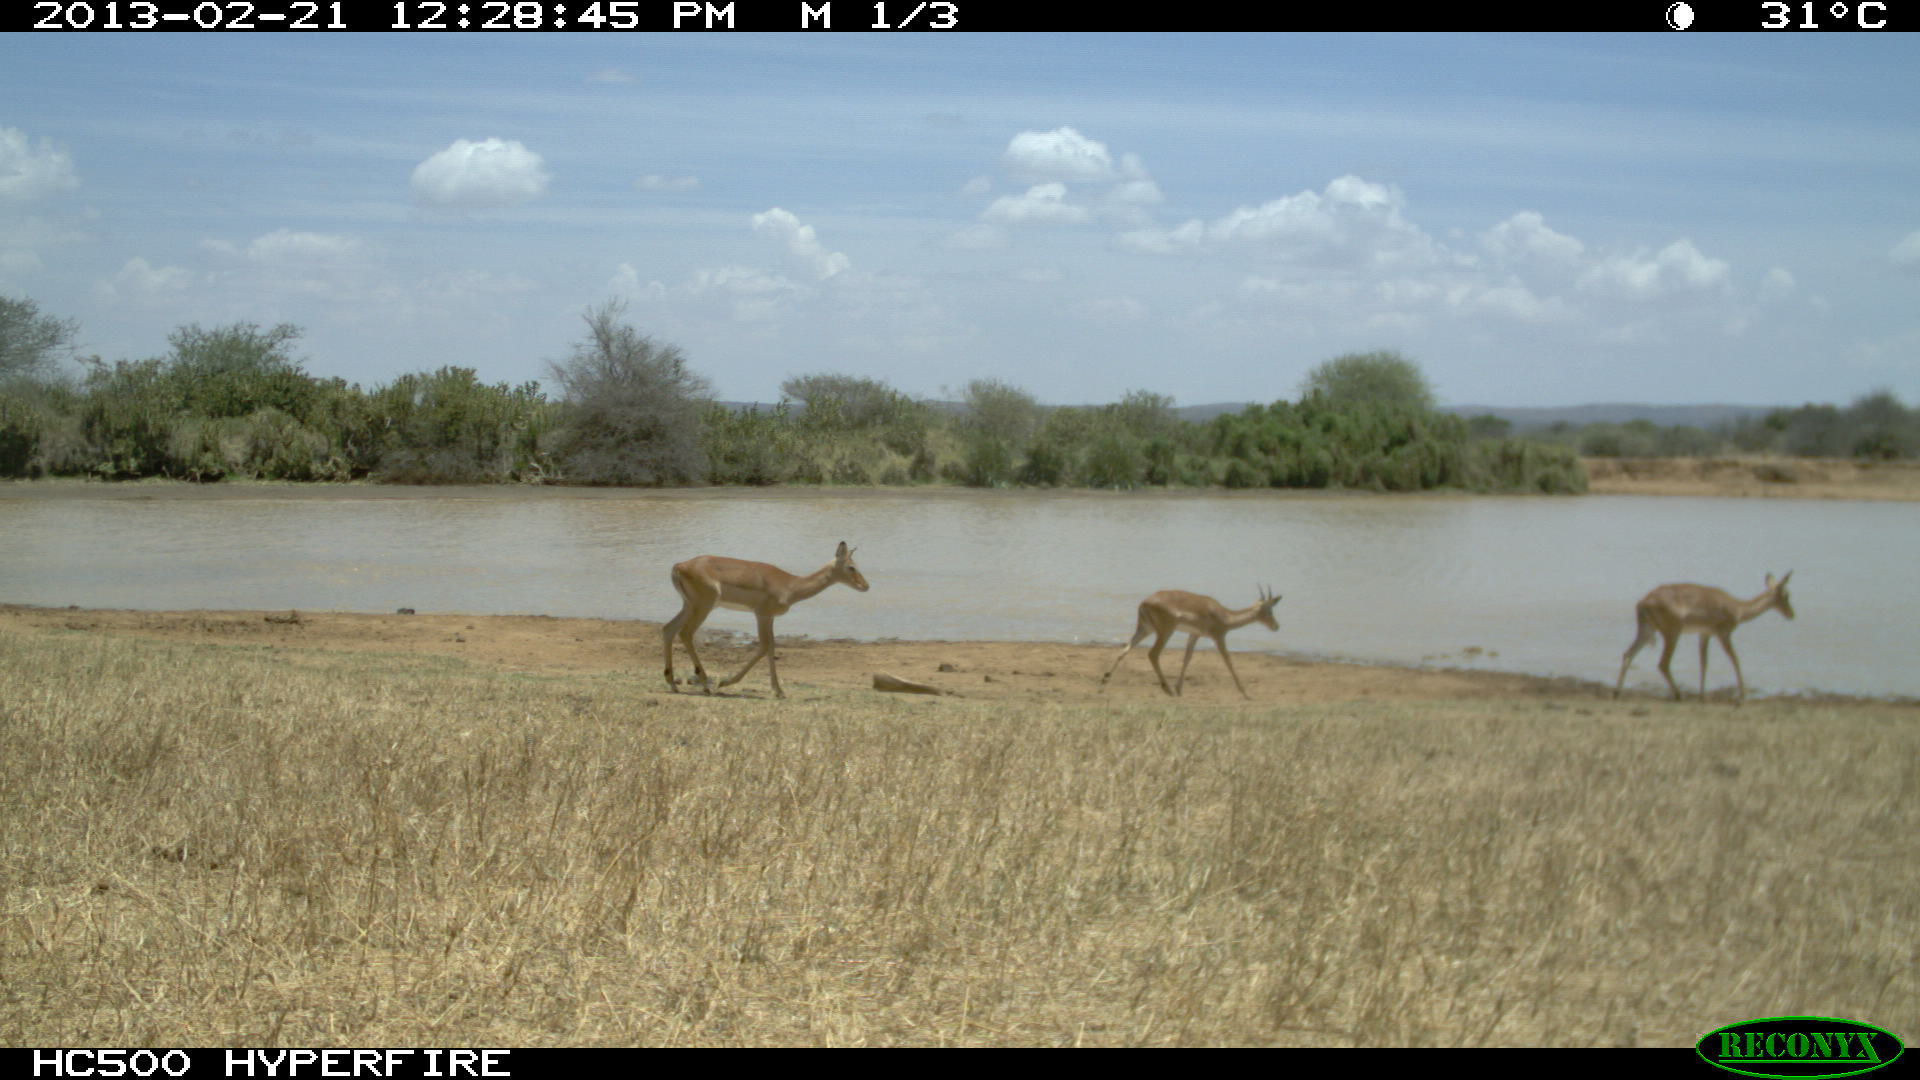

In [28]:
from IPython.display import Image
Image(filename="../input/iwildcam-2020-fgvc7/train/86760c00-21bc-11ea-a13a-137349068a90.jpg")


Train Data

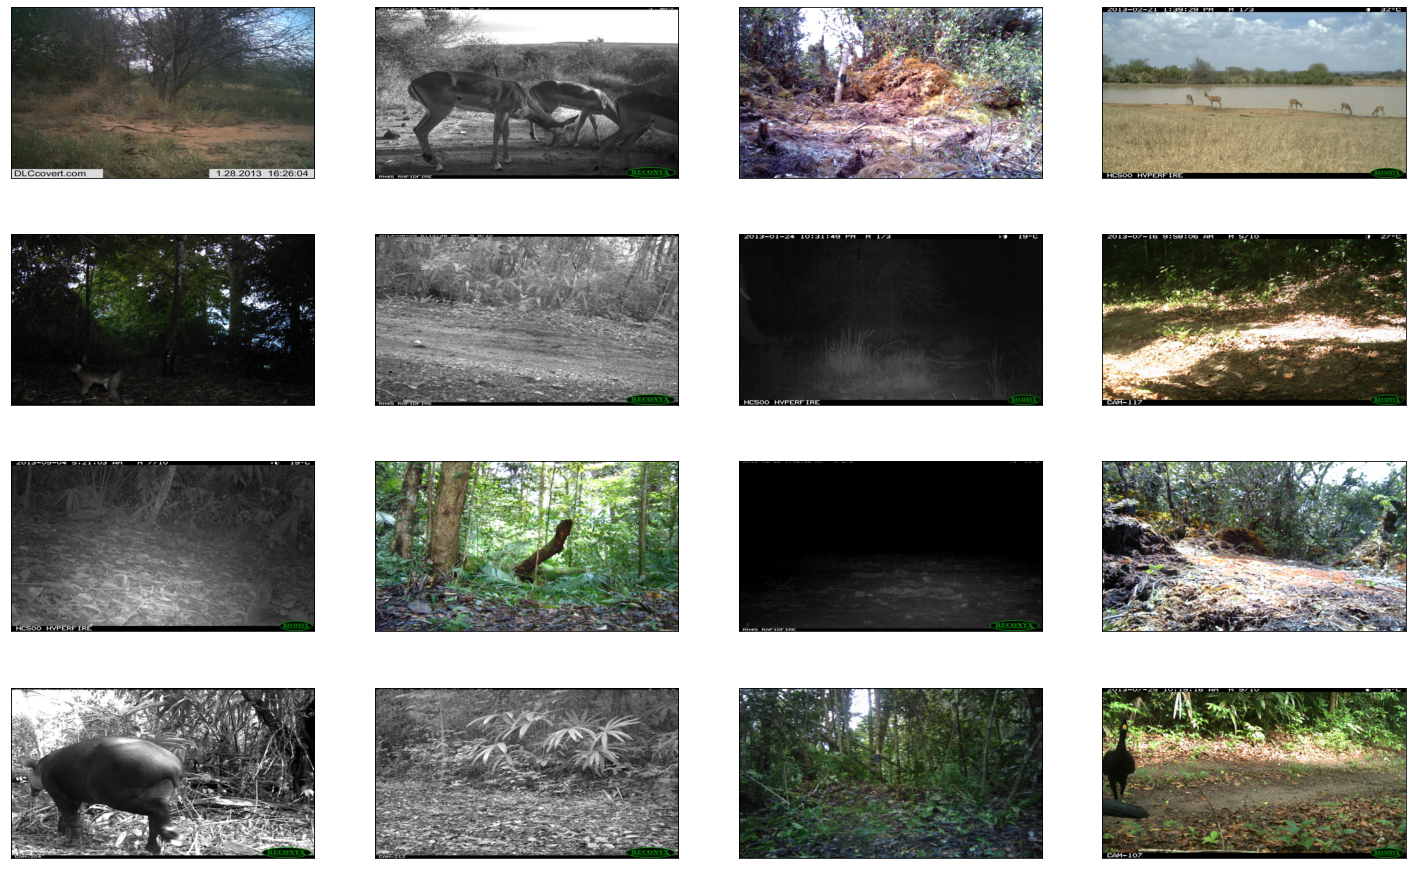

In [31]:
from PIL import Image

fig = plt.figure(figsize=(25, 16))
for i,im_path in enumerate(train_jpeg[:16]):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    im = Image.open(im_path)
    im = im.resize((480,270))
    plt.imshow(im)

**Test Data**

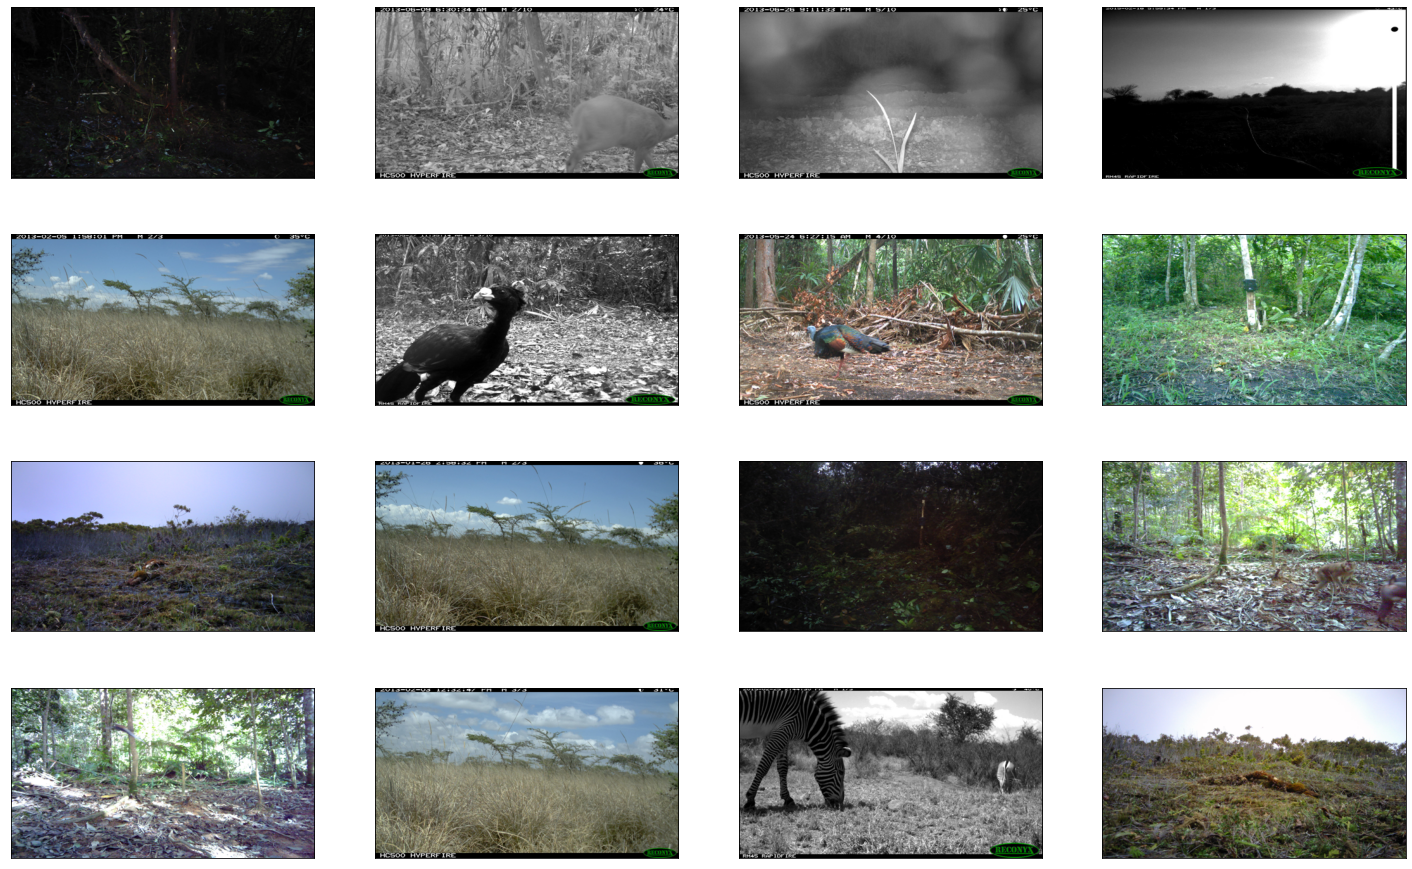

In [32]:
fig = plt.figure(figsize=(25, 16))
for i,im_path in enumerate(test_jpeg[:16]):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    im = Image.open(im_path)
    im = im.resize((480,270))
    plt.imshow(im)

## Data Analysis

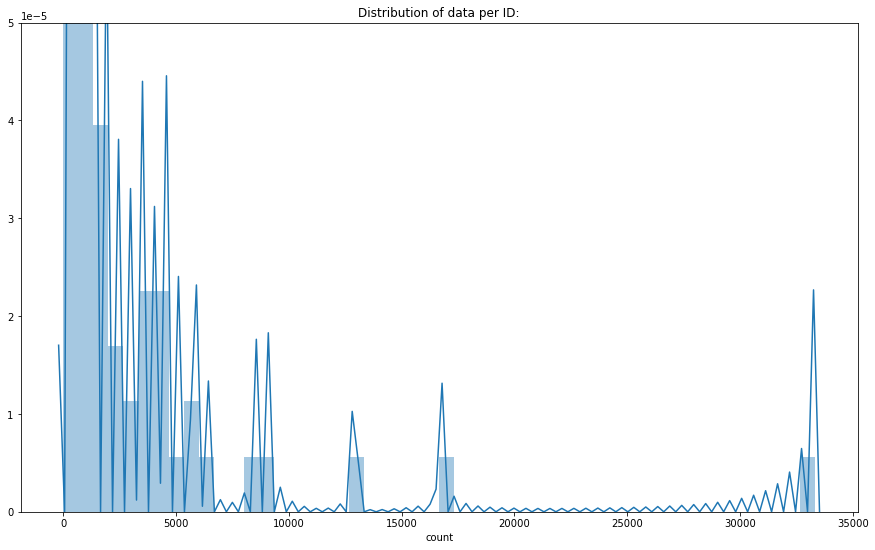

In [53]:
fig = plt.figure(figsize=(15, 9))
ax = sns.distplot(df_categories['count'][1:])
ax.set(ylim=(0,0.00005))
ax.set(xlabel='count')
plt.title('Distribution of data per ID:');

## Compiling the Model

In [99]:
from keras.applications.resnet50 import ResNet50

def get_model():
    K.clear_session()
    base_model =  ResNet50(weights='imagenet',
                           include_top=False,
                           pooling='avg',
                           input_shape=(224, 224, 3))
    
    x = base_model.output
    predictions = Dense(nb_classes, activation="softmax")(x)
    
    return Model(inputs=base_model.input, outputs=predictions)

model = get_model()

94773248/94765736 [==============================] - 1s 0us/step


In [100]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [101]:
model.compile(tf.keras.optimizers.Adam(lr=0.001, epsilon=1e-6,
                                      beta_1=0.9, beta_2=0.999), 
              loss="categorical_crossentropy",
              metrics=["accuracy"])

early = EarlyStopping(monitor='val_loss', 
                      min_delta=0, 
                      patience=3, 
                      verbose=1, 
                      mode='auto')

## MegaDetector Annotations

In [57]:
train_anns_df = labels[['image_id','category_id']]
train_img_df = image_df[['id', 'file_name']].rename(columns={'id':'image_id'})
df_train_file_cat = pd.merge(train_img_df, train_anns_df, on='image_id')
df_train_file_cat['category_id']=df_train_file_cat['category_id'].astype(str)
df_train_file_cat.head()

image_id  \
0  96b00332-21bc-11ea-a13a-137349068a90   
1  879d74d8-21bc-11ea-a13a-137349068a90   
2  9017f7aa-21bc-11ea-a13a-137349068a90   
3  90d93c58-21bc-11ea-a13a-137349068a90   
4  887cd0ec-21bc-11ea-a13a-137349068a90   

                                  file_name category_id  
0  96b00332-21bc-11ea-a13a-137349068a90.jpg          73  
1  879d74d8-21bc-11ea-a13a-137349068a90.jpg           4  
2  9017f7aa-21bc-11ea-a13a-137349068a90.jpg         227  
3  90d93c58-21bc-11ea-a13a-137349068a90.jpg         250  
4  887cd0ec-21bc-11ea-a13a-137349068a90.jpg           2

In [60]:
with open('../input/iwildcam-2020-fgvc7/iwildcam2020_megadetector_results.json', encoding='utf-8') as json_file:
    megadetector_results =json.load(json_file)
    
megadetector_results.keys()

dict_keys(['info', 'images', 'detection_categories'])

In [61]:
megadetector_results_df = pd.DataFrame(megadetector_results["images"])
megadetector_results_df.head()

detections  \
0  [{'category': '1', 'bbox': [0.6529, 0.5425, 0....   
1  [{'category': '1', 'bbox': [0.0147, 0.0, 0.985...   
2                                                 []   
3  [{'category': '1', 'bbox': [0.0, 0.4669, 0.185...   
4  [{'category': '1', 'bbox': [0.0, 0.0494, 0.528...   

                                     id  max_detection_conf  
0  905a3c8c-21bc-11ea-a13a-137349068a90               0.999  
1  905a3fc0-21bc-11ea-a13a-137349068a90               0.696  
2  905a420e-21bc-11ea-a13a-137349068a90               0.000  
3  905a4416-21bc-11ea-a13a-137349068a90               1.000  
4  905a579e-21bc-11ea-a13a-137349068a90               0.999

In [62]:
def draw_bboxs(detections_list, im):
    
    for detection in detections_list:
        x1, y1,w_box, h_box = detection["bbox"]
        ymin,xmin,ymax, xmax=y1, x1, y1 + h_box, x1 + w_box
        draw = ImageDraw.Draw(im)
        
        imageWidth=im.size[0]
        imageHeight= im.size[1]
        (left, right, top, bottom) = (xmin * imageWidth, xmax * imageWidth,
                                      ymin * imageHeight, ymax * imageHeight)
        
        draw.line([(left, top), (left, bottom), (right, bottom),
               (right, top), (left, top)], width=4, fill='Red')

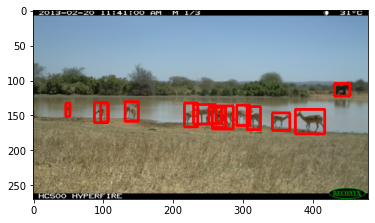

In [80]:
data_num = 5678

im = Image.open("../input/iwildcam-2020-fgvc7/train/" + megadetector_results_df.loc[data_num]['id'] + ".jpg")
im = im.resize((480,270))
draw_bboxs(megadetector_results_df.loc[data_num]['detections'], im)

plt.imshow(im);

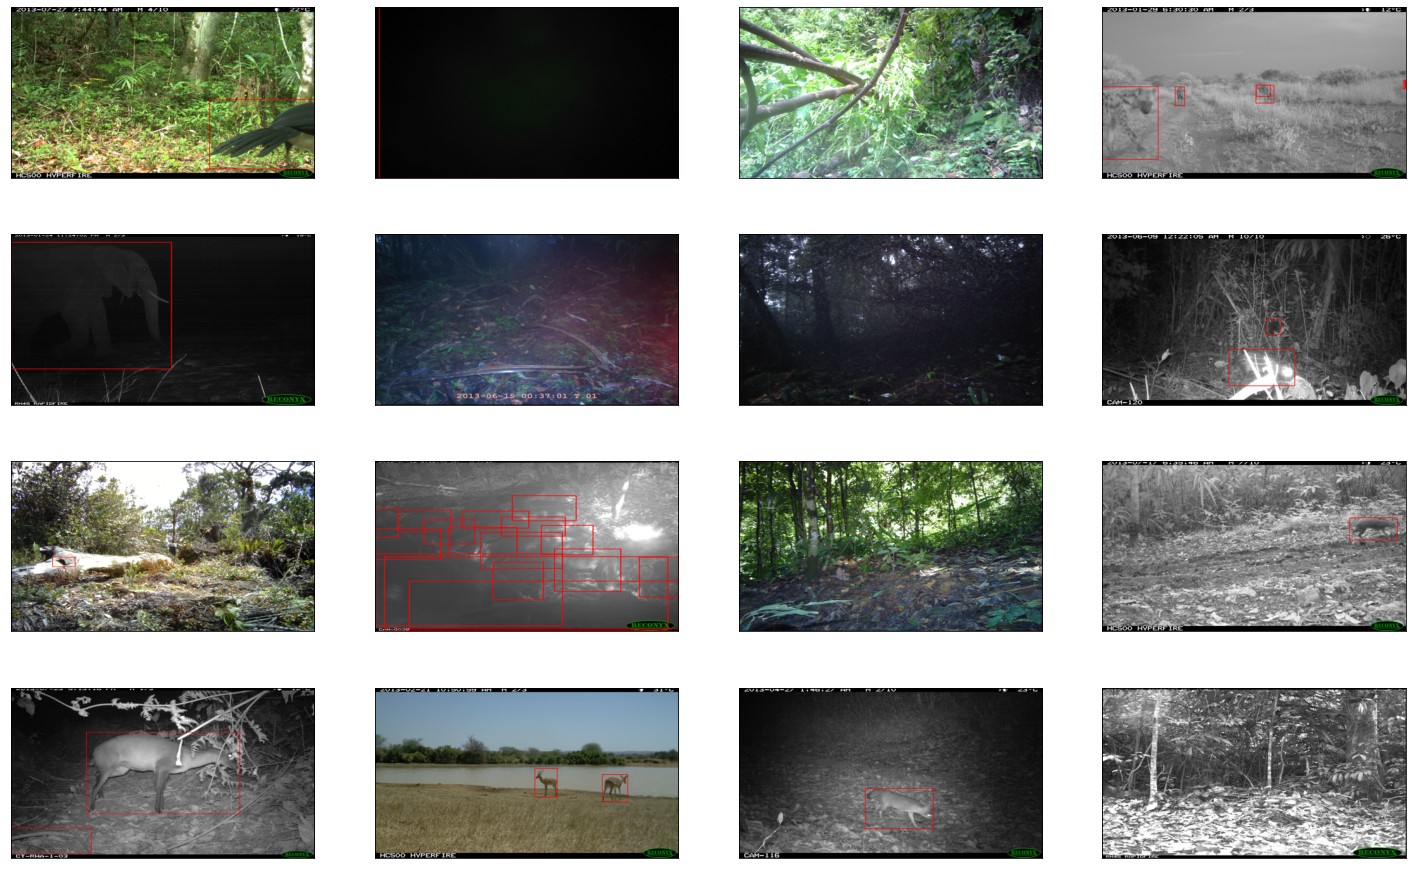

In [84]:
fig = plt.figure(figsize=(25, 16))

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    im = Image.open("../input/iwildcam-2020-fgvc7/train/" + megadetector_results_df.loc[i]['id'] + ".jpg")
    draw_bboxs(megadetector_results_df.loc[i]['detections'], im)
    im = im.resize((480,270))
    plt.imshow(im)

In [93]:
megadetector_results_df = megadetector_results_df[megadetector_results_df['detected_num'] < 2]
megadetector_results_df = megadetector_results_df.rename(columns={'id': 'image_id'})
megadetector_results_df.head()

detections  \
0  [{'category': '1', 'bbox': [0.6529, 0.5425, 0....   
1  [{'category': '1', 'bbox': [0.0147, 0.0, 0.985...   
2                                                 []   
4  [{'category': '1', 'bbox': [0.0, 0.0494, 0.528...   
5                                                 []   

                               image_id  max_detection_conf  detected_num  
0  905a3c8c-21bc-11ea-a13a-137349068a90               0.999             1  
1  905a3fc0-21bc-11ea-a13a-137349068a90               0.696             1  
2  905a420e-21bc-11ea-a13a-137349068a90               0.000             0  
4  905a579e-21bc-11ea-a13a-137349068a90               0.999             1  
5  905a5bae-21bc-11ea-a13a-137349068a90               0.000             0

In [94]:
def get_data(x):
    if x == []:
        return 0
    return len(x)

megadetector_results_df["detected_num"] = megadetector_results_df.loc[:, "detections"].map(get_data)

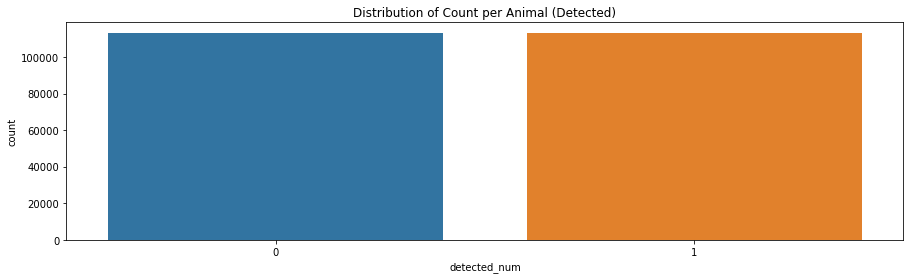

In [95]:
fig = plt.figure(figsize=(15, 4))
ax = sns.countplot(x="detected_num", data=megadetector_results_df)
ax.set(ylabel='count')
plt.title('Distribution of Count per Animal (Detected)');

## Data Preprocessing

In [103]:
batch_size = 256
img_size = 96
lr = 0.001 
nb_classes = 267
nb_epochs = 10

In [97]:
%%time

train_datagen=ImageDataGenerator(rescale=1./255, 
    validation_split=0.25,
    horizontal_flip = True,    
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3
    )

train_generator=train_datagen.flow_from_dataframe(    
    dataframe=df_train_file_cat[:50000],    
    directory="../input/iwildcam-2020-fgvc7/train",
    x_col="file_name",
    y_col="category_id",
    batch_size=batch_size,
    shuffle=True,
    classes = [ str(i) for i in range(nb_classes)],
    class_mode="categorical",    
    target_size=(img_size,img_size))

test_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=test_datagen.flow_from_dataframe(    
    dataframe=df_train_file_cat[50000:],    
    directory="../input/iwildcam-2020-fgvc7/train",
    x_col="file_name",
    y_col="category_id",
    batch_size=batch_size,
    shuffle=True,
    classes = [ str(i) for i in range(nb_classes)],
    class_mode="categorical",  
    target_size=(img_size,img_size))

Found 34565 validated image filenames belonging to 267 classes.
Found 84889 validated image filenames belonging to 267 classes.
CPU times: user 4.05 s, sys: 4.07 s, total: 8.12 s
Wall time: 38.8 s


## Training

In [110]:
%%time
history = model.fit_generator(generator=train_generator,  
                                    steps_per_epoch=5,
                                    validation_data=valid_generator, 
                                    validation_steps=2,
                                    epochs=nb_epochs,
                                    callbacks = [early],
                                    verbose=2)

Epoch 1/10
5/5 - 89s - loss: 1.2917 - accuracy: 0.6750 - val_loss: 77.6221 - val_accuracy: 0.5840
Epoch 2/10
5/5 - 80s - loss: 1.3903 - accuracy: 0.6781 - val_loss: 49.9670 - val_accuracy: 0.5625
Epoch 3/10
5/5 - 79s - loss: 1.2363 - accuracy: 0.6773 - val_loss: 52.4087 - val_accuracy: 0.6133
Epoch 4/10
5/5 - 78s - loss: 1.1968 - accuracy: 0.6789 - val_loss: 21.7561 - val_accuracy: 0.6094
Epoch 5/10
5/5 - 77s - loss: 1.1717 - accuracy: 0.6906 - val_loss: 12.3403 - val_accuracy: 0.0078
Epoch 6/10
5/5 - 77s - loss: 1.1084 - accuracy: 0.7031 - val_loss: 12.2702 - val_accuracy: 0.6016
Epoch 7/10
5/5 - 78s - loss: 1.1601 - accuracy: 0.6742 - val_loss: 16.2386 - val_accuracy: 0.6016
Epoch 8/10
5/5 - 79s - loss: 1.0856 - accuracy: 0.7141 - val_loss: 10.9696 - val_accuracy: 0.5703
Epoch 9/10
5/5 - 76s - loss: 1.1091 - accuracy: 0.6961 - val_loss: 3.7414 - val_accuracy: 0.0039
Epoch 10/10
5/5 - 76s - loss: 1.0537 - accuracy: 0.7070 - val_loss: 4.0135 - val_accuracy: 0.0293
CPU times: user 16min

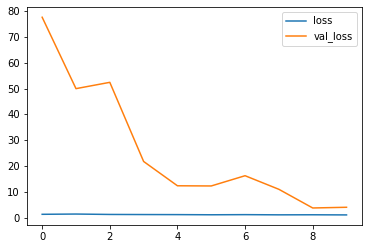

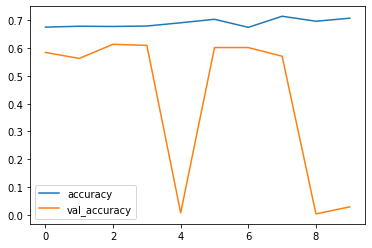

In [112]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot();
history_df[['accuracy', 'val_accuracy']].plot();

In [116]:
model.save("resnet50.h5")

## Predictions

In [113]:
sam_sub_df = pd.read_csv('../input/iwildcam-2020-fgvc7/sample_submission.csv')
sam_sub_df["file_name"] = sam_sub_df["Id"].map(lambda str : str + ".jpg")
sam_sub_df.head()

Id  Category  \
0  873ff218-21bc-11ea-a13a-137349068a90       669   
1  884103be-21bc-11ea-a13a-137349068a90       191   
2  973feb64-21bc-11ea-a13a-137349068a90       245   
3  8ebf4e44-21bc-11ea-a13a-137349068a90       335   
4  95a33464-21bc-11ea-a13a-137349068a90       328   

                                  file_name  
0  873ff218-21bc-11ea-a13a-137349068a90.jpg  
1  884103be-21bc-11ea-a13a-137349068a90.jpg  
2  973feb64-21bc-11ea-a13a-137349068a90.jpg  
3  8ebf4e44-21bc-11ea-a13a-137349068a90.jpg  
4  95a33464-21bc-11ea-a13a-137349068a90.jpg

In [114]:
%%time

test_generator = test_datagen.flow_from_dataframe(      
    
        dataframe=sam_sub_df,    
    
        directory = "../input/iwildcam-2020-fgvc7/test",    
        x_col="file_name",
        target_size = (img_size,img_size),
        batch_size = 1,
        classes = [ str(i) for i in range(nb_classes)],
        shuffle = False,
        class_mode = None
        )

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:220: UserWarning: `classes` will be ignored given the class_mode="None"
  .format(self.class_mode))


Found 62870 validated image filenames.
CPU times: user 983 ms, sys: 1.65 s, total: 2.64 s
Wall time: 12.1 s


In [120]:
%%time

test_generator.reset()
predict=model.predict_generator(test_generator,
                                steps = len(test_generator.filenames))

predicted_class_indices = np.argmax(predict, axis=1)

sam_sub_df["Category"] = predicted_class_indices
sam_sub_df = sam_sub_df.loc[:,["Id", "Category"]]
sam_sub_df.to_csv("submission.csv", index=False)

CPU times: user 38min 34s, sys: 36.4 s, total: 39min 11s
Wall time: 37min 20s


## Conclusion

It can be concluded that given enough resources, it is possible for a network to detect and predict the species of a wild animal.